<a href="https://colab.research.google.com/github/dssp-ethz/DSSP-Illustrations/blob/main/Trellis_Algorithms.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Viterbi Algorithm

Many optimization problems can be modelled using a Trellis diagram. In a Trellis diagram each path from the initial node (A) to the terminal node (K) uses the same number of branches. Thus the graph may be subdivided into several sections $n$ with a different set of branches. With the number of paths depending exponentially on $n$ (width of Trellis Diagram only changes base of exponentiation) finding the optimal path becomes infeasible in long Trellis Diagrams using an exhaustive search algorithm (brute force).

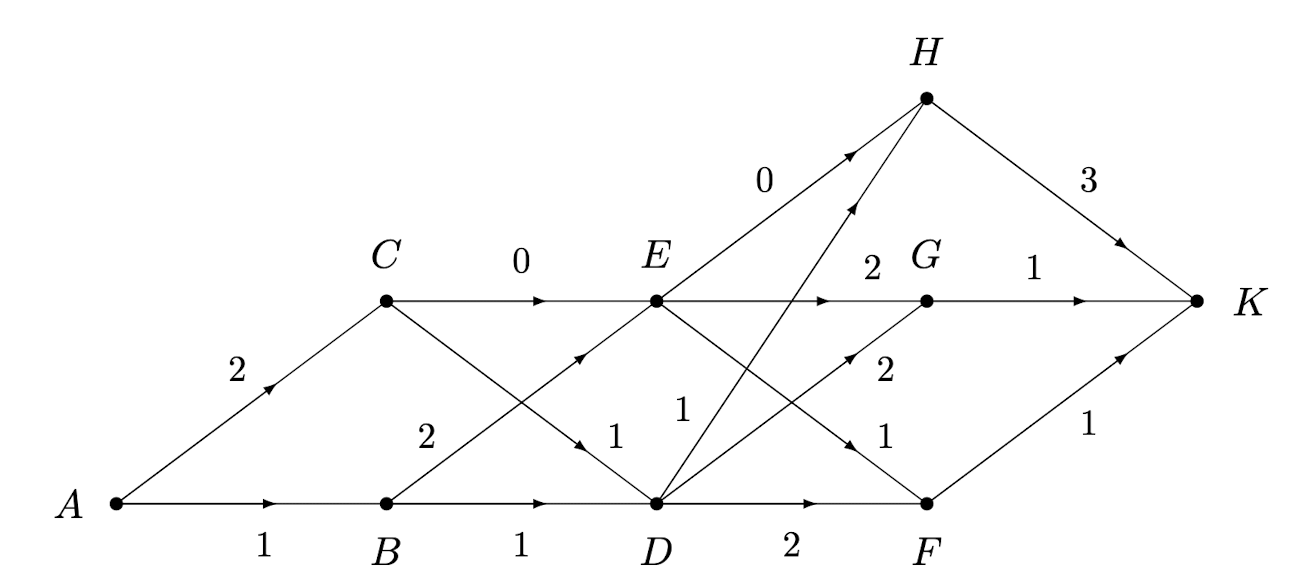

Lucky for us there is an algorithm, called Viterbi algorithm, which can compute the optimal path linearly in $n$. Viterbi algorithm is essentially Dijkstra's algorithm reduced to Trellis Diagrams (in case you know about the latter). Since it reuses past computations instead of repeating everything it is an example of dynamic programming. The viterbi algorithm is now presented:

**Viterbi Algorithm (min-sum version)**


*   **path metric** = sum of branch metrics
*   **initialization**: $\mu(s) = 0$ for all initial states $s$
*   **recursive computation of state metrics:**
    $\mu(s) = \min\limits_{\text{branches } b \text{ with } rst(b) = s} \mu(lst(b)) + \mu(b)$
    and recording the minimizing branch $b$ to each state $s$
*   **main property**: $\mu(s) =$ minimal path metric from any initial state to state $s$.





The code cell below implements the viterbi algorithm. Note that this is not production code and thus runs fairly slowly, on the other hand it is close to pseudocode. It will be reused for the subsequent cells.

In [ ]:
import numpy as np
import math

def viterbi(B, S_i): #min-sum version
    """
    Returns the path of least path metric

    Parameters
    ----------
    B : 3D nested list, each outer element holds one section of branches (between 2 layers) encoded as a matrix (row-from, column-to). Inner elements encode metric of branch
    S_i: 1D list, initialize state metric of first layer

    Returns
    -------
    S : 2D nested list, lists state metrics layer by layer
    P : 2D nested list, lists minimizing prestates layer by layer
    """

    #check dimensionality of Trellis structure
    assert len(S_i) == len(B[0]), "S_i should fit the Trellis structure given by B in terms of dimensionality"
    for i in range(len(B)-1):
      assert len(B[i][0]) == len(B[i+1]), "the width of each layer of states should not depend if you look at it from the left or the right section of branches"

    #iterate through graph to compute state metrics
    #---------------------------------------------------------------------------

    #Initialize S and P
    S = [S_i] #list of states layer by layer with their metric
    P = [[None]*len(S_i)] #list of precursors for each state, same dimensions as S

    #iterate over sections to update states on the right side of it
    for section_index, section in enumerate(B):
      #layer of states to the right
      S_layer = []  #metrics
      P_layer = []  #prestates (0 indexed)
      for state_index in range(len(section[0])): #columns correspond to right layer
        state_metric = math.inf #unless better path is found
        state_prestate = None #unless better path is found

        #goes through prestates to find minimizer
        for prestate_index, prestate_metric in enumerate(S[section_index]):
          potential_metric = prestate_metric + section[prestate_index][state_index] #might be better than metric so far
          if potential_metric < state_metric:
            state_metric = potential_metric
            state_prestate = prestate_index
        S_layer += [state_metric]
        P_layer += [state_prestate]
      #add layer of state metrics and prestate indices
      S += [S_layer]
      P += [P_layer]
    
    return (S, P)

## Statistical Model

Let $W = (W_1, W_2, \ldots, W_n)$ be a random path (encded with edges) in a Trellis data structure. Assume we have an observation $Y_k$ for each section depending only on the chosen edge $W_k$ (i.i.d.). By giving the branches as weights the maximum likelihood estimate of $W_k$ the most likely random path is just the one which maximizes
$$f_{Y|W} (y|w) = \prod\limits_{k=1}^n f_{Y_k|W_k} (y_k|w_k)$$

### Problem 6.5 (as of 2020)

Let $y = (y_1, y_2, y_3, y_4, y_5)$ be a noisy version of a data file. We wish to reconstruct the original file $x=(x_1,x_2, x_3, x_4, x_5)\quad x_i \in \{0,1\}$. Luckily the original data has structure that introduces some redundancy. We shall use said redundancy to reconstruct the most likely data. We know that



1.   1 is always followed by 0
2.   single 0 is followed by 0 or 1 equiprobably
3.   Two zeros are always followed by 1
4.   $x_1$ is 0 or 1 equiprobably

From that we construct the trellis diagram:

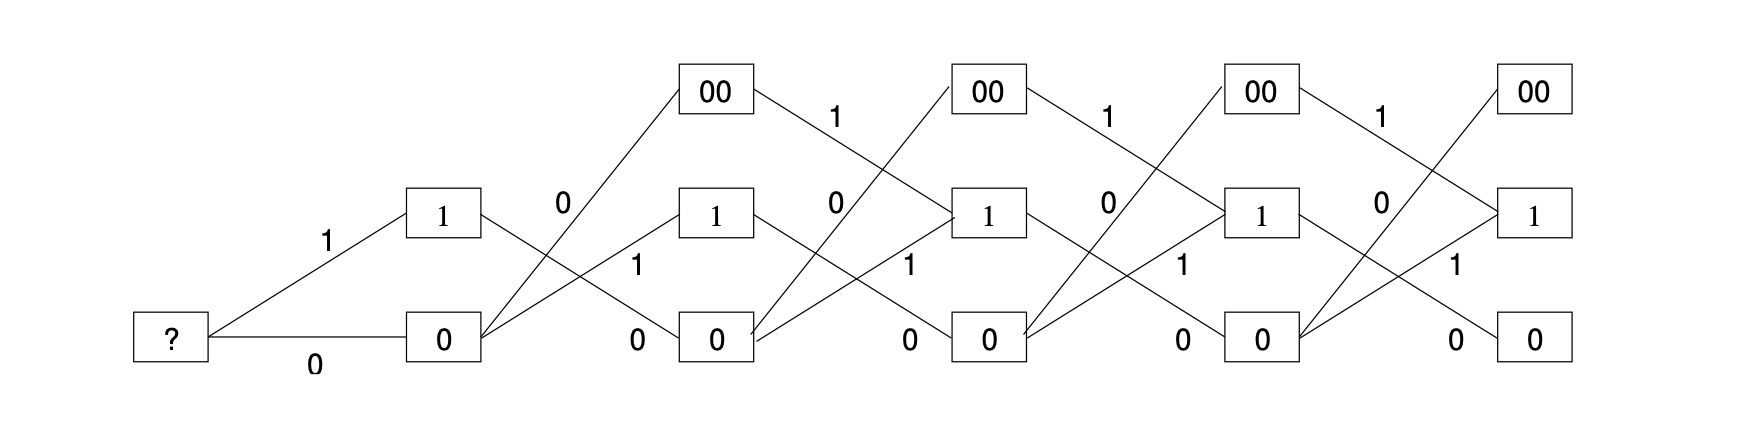

We assume $y$ was obtained from $x$ where each bit was independently flipped with probability $\epsilon$.
The following code snippet allows you to set all parameters of the task (make sure you enter 5 observed bits with white space between).

In [ ]:
import ipywidgets as widgets
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import networkx as nx #used to draw graph
#-------------------------------------------------------------------------------

#read in parameters
epsilonG = 0.1
yG = [0, 1, 1, 0, 0]
def update_parameters(epsilon, y):
  global epsilonG, yG
  try:
    y = [int(v) for v in y.split()]
    if len(y) != 5:
      raise #only length 5 bit arrays are accepted (problem statement)
    for e in y:
      if e != 0 and e != 1:
        raise #only bits allowed as observables
    epsilonG, yG = epsilon, y
  except:
    pass
widgets.interact(update_parameters, epsilon = widgets.FloatSlider(min=0.1, max=0.9, value=0.1), y = '0 1 1 0 0');

interactive(children=(FloatSlider(value=0.1, description='epsilon', max=0.9, min=0.1), Text(value='0 1 1 0 0',…

With these properties the statistical model is fairly simple. We have
$$f_{Y_k|X_k} (y_k|x_k) = \begin{cases} 1-\epsilon & y_k = x_k\\ \epsilon & y_k \neq x_k \end{cases}$$
Wishing to use the min-sum version of the Viterbi algorithm we must transform the maximization of the product of branches into the minimization of the sum of branches. With
$$-\ln\left(f_{Y|W} (y|w)\right) = -\ln\left(\prod\limits_{k=1}^n f_{Y_k|W_k} (y_k|w_k)\right) = \sum\limits_{k=1}^n -\ln\left(f_{Y_k|W_k}\right)$$
the min-sum Viterbi algorithm will do the trick.

The code snippet below runs the Viterbi algorithm for the established Trelli's diagram and statistical model to get the most likely original data. What do you notice if you increase $\epsilon$?.

In [ ]:
import copy

#statistical model
def likelihoood(y, x, epsilon):
  if x == y:
    return 1 - epsilon
  else:
    return epsilon
    
def neg_log_likelhiood(y, x, epsilon):
  return - np.log(likelihoood(y, x, epsilon))

#encode particular Trellis (0/1 indicate x_i), outer array selects section with matrix elements denoting the branches from (row) prestates to (column) states.
T = [
     [
      [0, 1]
     ],
     [
      [None, 1, 0],
      [0, None, None]
     ],
     [
      [None, 1, 0],
      [0, None, None],
      [None, 1, None]
     ],
     [
      [None, 1, 0],
      [0, None, None],
      [None, 1, None]
     ],
     [
      [None, 1, 0],
      [0, None, None],
      [None, 1, None]
     ]
    ]
def run_viterbi():
  #compute branch metrics depending on observables:
  B = copy.deepcopy(T) #same dimensionality as Trellis branches

  for i_section in range(len(B)):
    for ix in range(len(B[i_section])):
      for iy in range(len(B[i_section][ix])):
        if T[i_section][ix][iy] == None:
          B[i_section][ix][iy] = math.inf #branch shall not be taken, basically removes it
        else:
          B[i_section][ix][iy] = neg_log_likelhiood(yG[i_section], T[i_section][ix][iy], epsilonG)
  #initialize state metric to 0 at start
  S_i = [0]

  #run viterbi algorithm (S are state metrics, P are prenodes)
  S, P = viterbi(B, S_i)

  #plotting Trellis graph
  ################################################################################
  plt.figure(1,figsize=(16,8)) 
  Trellis = nx.DiGraph()
  Trellis.add_edges_from(
      [('?', 'x_1 = 0'), ('?', 'x_1 = 1'), 
        ('x_1 = 0', 'x_2 = 1'), ('x_1 = 0', 'x_2- = 00'), ('x_1 = 1', 'x_2 = 0'),
        ('x_2 = 0', 'x_3 = 1'), ('x_2 = 0', 'x_3- = 00'), ('x_2 = 1', 'x_3 = 0'), ('x_2- = 00', 'x_3 = 1'),
        ('x_3 = 0', 'x_4 = 1'), ('x_3 = 0', 'x_4- = 00'), ('x_3 = 1', 'x_4 = 0'), ('x_3- = 00', 'x_4 = 1'),
        ('x_4 = 0', 'x_5 = 1'), ('x_4 = 0', 'x_5- = 00'), ('x_4 = 1', 'x_5 = 0'), ('x_4- = 00', 'x_5 = 1')])

  #colours used and unused edges
  edge_colours = ['red']*len(Trellis.edges())
  for i_layer in range(len(P)):
    for node, pre_node in enumerate(P[i_layer]):
      from_label = ''
      to_label = 'x_{}{} = {}'.format(i_layer, '-' if node == 2 else '', '00' if node == 2 else node) 
      if i_layer == 0:
        break
      elif i_layer == 1:
        from_label = '?'
      else:
        from_label = 'x_{}{} = {}'.format(i_layer-1, '-' if pre_node == 2 else '', '00' if pre_node == 2 else pre_node)

      edge_colours[list(Trellis.edges()).index((from_label, to_label))] = 'black' #actually used edges

  #colours most likely path
  to_layer = len(S)-1
  to_node = np.argmax(S[to_layer])
  while to_layer > 0:
    from_node = P[to_layer][to_node]
    to_label = 'x_{}{} = {}'.format(to_layer, '-' if to_node == 2 else '', '00' if to_node == 2 else to_node)
    from_label = ''
    if to_layer == 1:
      from_label = '?'
    else:
      from_label = 'x_{}{} = {}'.format(to_layer-1, '-' if from_node == 2 else '', '00' if from_node == 2 else from_node)

    edge_colours[list(Trellis.edges()).index((from_label, to_label))] = 'blue' #MLE edges

    #propagate back
    to_node = from_node
    to_layer -= 1

  black_edges = [edge for edge in Trellis.edges() if edge_colours[list(Trellis.edges()).index(edge)] == 'black']
  red_edges = [edge for edge in Trellis.edges() if edge_colours[list(Trellis.edges()).index(edge)] == 'red']
  blue_edges = [edge for edge in Trellis.edges() if edge_colours[list(Trellis.edges()).index(edge)] == 'blue']

  """ #node colouring most likely node in a given sequence, deactivated
  node_colours = ['black']*len(Trellis.nodes())
  for i_layer in range(len(S)):
    max_metric = np.max(S[i_layer])
    for state_index, state_metric in enumerate(S[i_layer]):
      label = ''
      if i_layer == 0:
        label = '?'
      else:
        label = 'x_{}{} = {}'.format(i_layer, '' if state_index != 2 else '-', state_index if state_index != 2 else '00')
      if state_metric == max_metric:
        node_colours[list(Trellis.nodes()).index(label)] = 'blue'

  black_nodes = [node for node in Trellis.nodes() if node_colours[list(Trellis.nodes()).index(node)] == 'black']
  blue_nodes = [node for node in Trellis.nodes() if node_colours[list(Trellis.nodes()).index(node)] == 'blue']
  """

  pos = nx.spring_layout(Trellis, pos = {'?': (-1, -1),
                                                      'x_1 = 0' : (-0.5, -1), 'x_1 = 1' : (-0.5, 0),
                                                      'x_2 = 0' : (0, -1), 'x_2 = 1' : (0, 0), 'x_2- = 00' : (0, 1),
                                                      'x_3 = 0' : (0.5, -1), 'x_3 = 1' : (0.5, 0), 'x_3- = 00' : (0.5, 1),
                                                      'x_4 = 0' : (1, -1), 'x_4 = 1' : (1, 0), 'x_4- = 00' : (1, 1),
                                                      'x_5 = 0' : (1.5, -1), 'x_5 = 1' : (1.5, 0), 'x_5- = 00' : (1.5, 1)},
                          fixed = ['?',
                                                      'x_1 = 1', 'x_1 = 0',
                                                      'x_2 = 1', 'x_2 = 0', 'x_2- = 00',
                                                      'x_3 = 1', 'x_3 = 0', 'x_3- = 00',
                                                      'x_4 = 1', 'x_4 = 0', 'x_4- = 00',
                                                      'x_5 = 1', 'x_5 = 0', 'x_5- = 00'])

  nx.draw_networkx_nodes(Trellis, pos, node_color = 'black', node_size = 80)
  nx.draw_networkx_labels(Trellis, pos, font_size = 18, verticalalignment = 'bottom')
  nx.draw_networkx_edges(Trellis, pos, edgelist = black_edges, arrows  = False)
  nx.draw_networkx_edges(Trellis, pos, edgelist = red_edges, edge_color = 'r', style = 'dashed', arrows = False)
  nx.draw_networkx_edges(Trellis, pos, edgelist = blue_edges, width = 2, edge_color = 'b', arrows = False)
  plt.show()

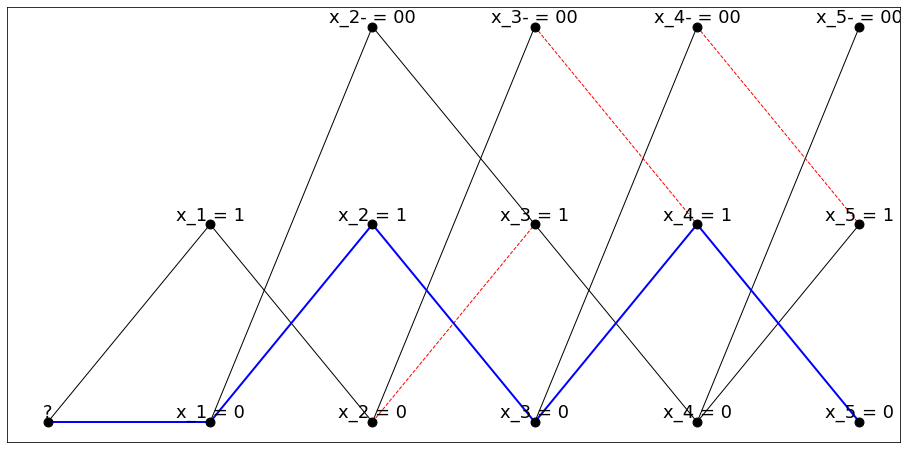

In [ ]:
run_viterbi()

You should be able to distinguish the MLE path in the Trellis diagram. The red dashed lines are discarded since they are in any case not part of the most efficient path to a given node. The blue edges describe the most likely path.